# Лабораторная работа 2: Классификация кредитных заявок

## Задача
Предсказание одобрения кредита (LoanApproved) на основе персональных и финансовых данных.

**Основная метрика:** ROC-AUC (минимум 0.75 для допуска к защите)

In [71]:
# Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import BaggingClassifier as SklearnBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier as SklearnGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
import warnings
import time
from copy import deepcopy

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("Библиотеки загружены, Великолепно!")

Библиотеки загружены, Великолепно!


## 1. EDA - Разведочный анализ данных

In [72]:
# Загрузка данных
train_df = pd.read_csv('data/data_lab2/train_c.csv')
test_df = pd.read_csv('data/data_lab2/test_c.csv')

print(f"Тренировочные данные: {train_df.shape}")
print(f"Тестовые данные: {test_df.shape}")
print(f"\nКолонки тренировочных данных:\n{train_df.columns.tolist()}")
print(f"\nПервые строки:")
train_df.head()

Тренировочные данные: (11017, 35)
Тестовые данные: (5000, 35)

Колонки тренировочных данных:
['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']

Первые строки:


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


In [73]:
# Анализ структуры данных
print("Информация о данных:")
print(train_df.info())
print("\n" + "="*50)
print("\nПропущенные значения:")
missing = train_df.isnull().sum()
print(missing[missing > 0])
print("\n" + "="*50)
print("\nТипы данных:")
print(train_df.dtypes.value_counts())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToInco

Распределение целевой переменной LoanApproved:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Процентное соотношение:
LoanApproved
1.0    51.177649
0.0    48.822351
Name: proportion, dtype: float64


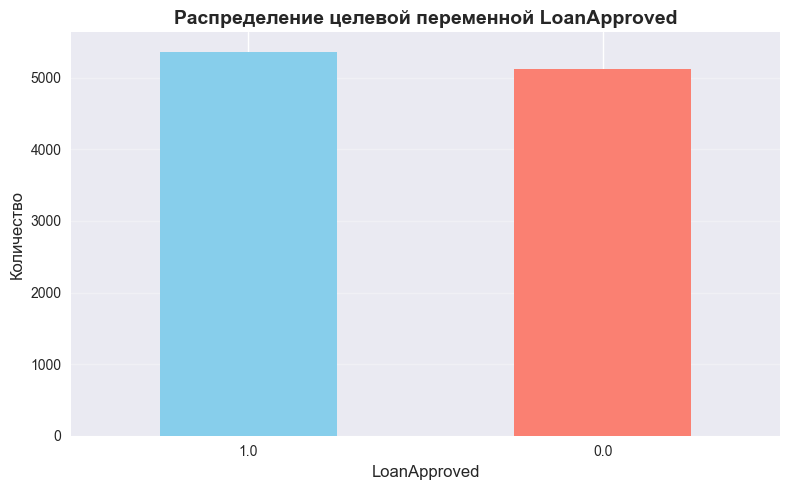

In [74]:
# Анализ целевой переменной
print("Распределение целевой переменной LoanApproved:")
print(train_df['LoanApproved'].value_counts())
print(f"\nПроцентное соотношение:")
print(train_df['LoanApproved'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 5))
train_df['LoanApproved'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение целевой переменной LoanApproved', fontsize=14, fontweight='bold')
plt.xlabel('LoanApproved', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [75]:
# Разделение на численные и категориальные признаки
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Удаление целевой переменной из численных
if 'LoanApproved' in numeric_cols:
    numeric_cols.remove('LoanApproved')

print(f"Численные признаки ({len(numeric_cols)}):")
print(numeric_cols)
print(f"\nКатегориальные признаки ({len(categorical_cols)}):")
print(categorical_cols)

Численные признаки (28):
['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']

Категориальные признаки (6):
['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


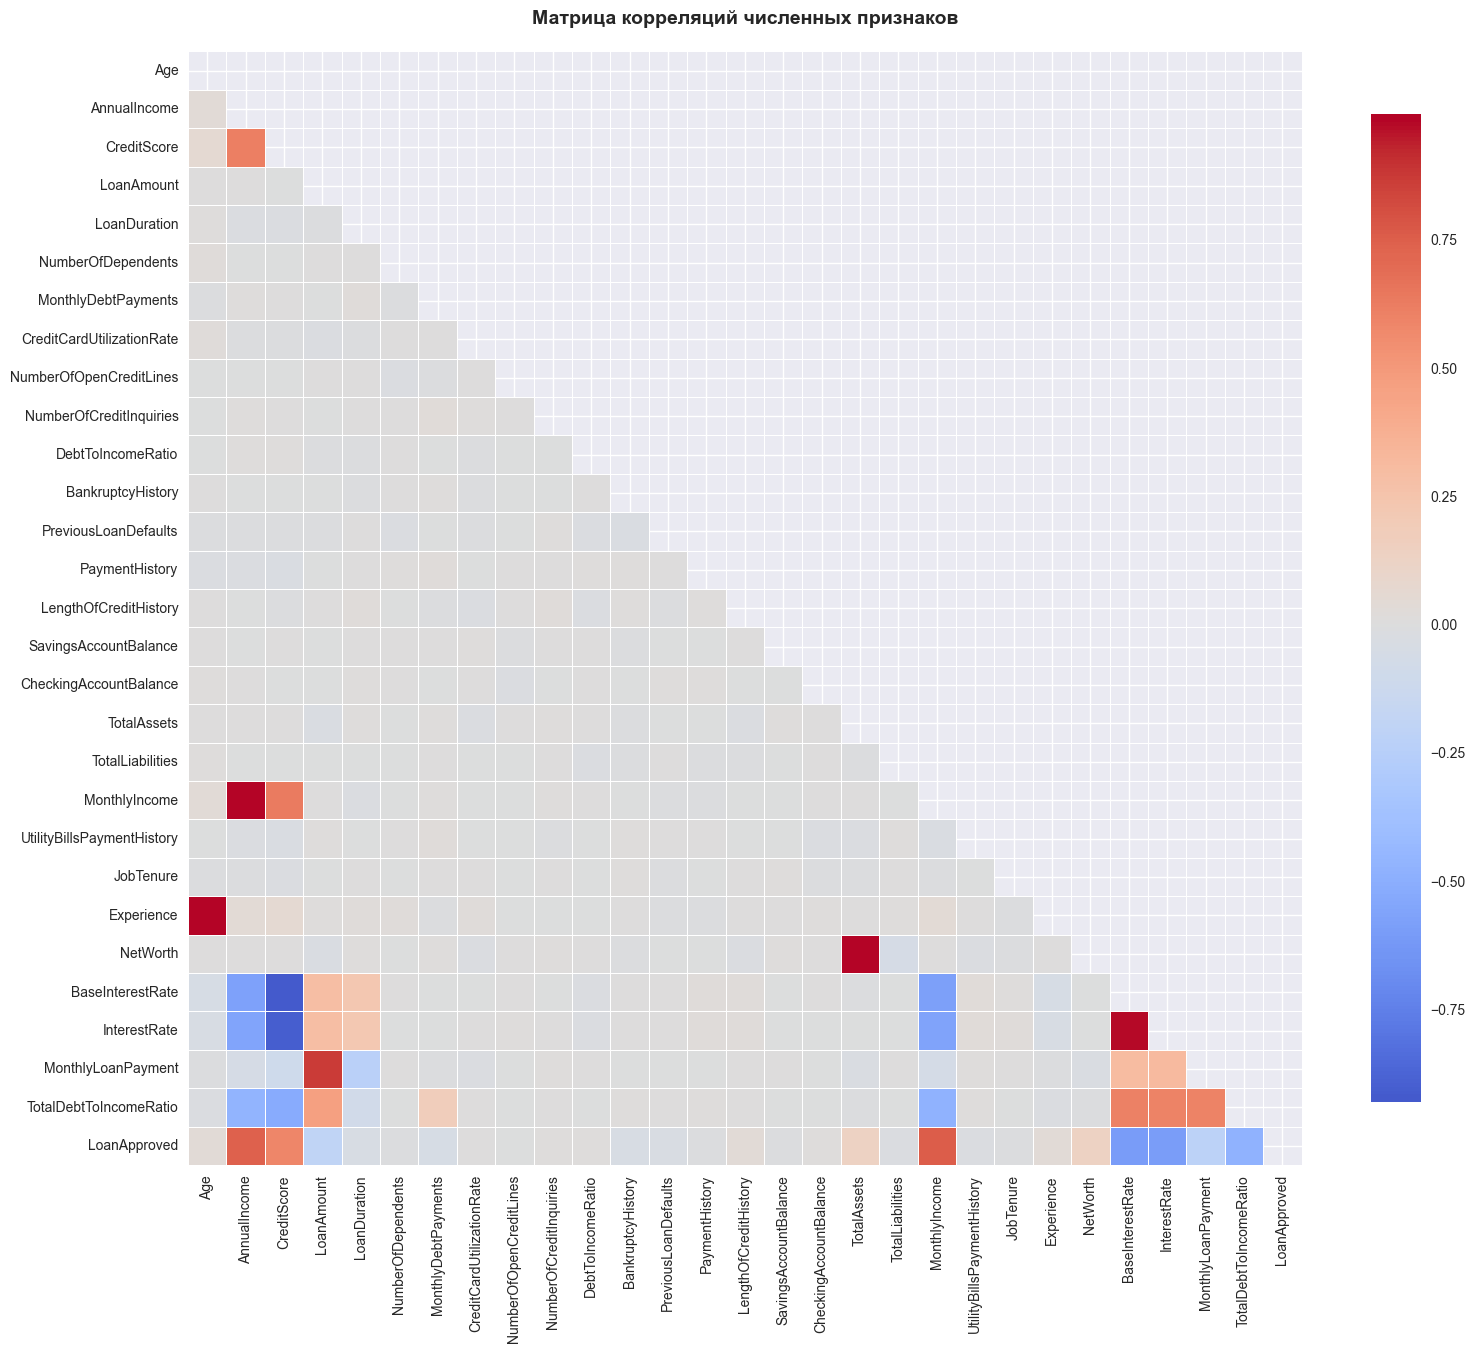


Топ-10 признаков с наибольшей корреляцией с LoanApproved:
MonthlyIncome              0.754853
AnnualIncome               0.743034
CreditScore                0.581812
NetWorth                   0.129624
TotalAssets                0.129204
LengthOfCreditHistory      0.038509
Experience                 0.036699
Age                        0.036580
DebtToIncomeRatio          0.014922
NumberOfCreditInquiries    0.012520
Name: LoanApproved, dtype: float64


In [76]:
# Матрица корреляций для численных признаков
numeric_data = train_df[numeric_cols + ['LoanApproved']]
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Матрица корреляций численных признаков', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Корреляции с целевой переменной
target_corr = correlation_matrix['LoanApproved'].sort_values(ascending=False)
print("\nТоп-10 признаков с наибольшей корреляцией с LoanApproved:")
print(target_corr[1:11])  # Исключение самой целевой переменной

In [77]:
# Подготовка данных для обучения
# Проверка и обработка пропущенных значений в целевой переменной
print("Проверка пропущенных значений в LoanApproved:")
print(f"NaN значений: {train_df['LoanApproved'].isna().sum()}")
print(f"Уникальные значения: {train_df['LoanApproved'].unique()}")

# Удаление строк с пропущенными значениями в целевой переменной
train_df_clean = train_df.dropna(subset=['LoanApproved']).copy()
print(f"\nРазмер данных до очистки: {train_df.shape}")
print(f"Размер данных после очистки: {train_df_clean.shape}")

# Разделение на признаки и целевую переменную
X_train_full = train_df_clean.drop('LoanApproved', axis=1)
y_train_full = train_df_clean['LoanApproved'].astype(int)

# Разделение на train и validation (stratified для сохранения баланса классов)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nTrain: {X_train.shape}, Validation: {X_val.shape}")
print(f"Распределение классов в train: {y_train.value_counts().to_dict()}")
print(f"Распределение классов в validation: {y_val.value_counts().to_dict()}")

# Сохранение ID для тестового набора
test_ids = test_df['ID'].copy()
X_test = test_df.drop('ID', axis=1)

Проверка пропущенных значений в LoanApproved:
NaN значений: 530
Уникальные значения: [ 0.  1. nan]

Размер данных до очистки: (11017, 35)
Размер данных после очистки: (10487, 35)

Train: (8389, 34), Validation: (2098, 34)
Распределение классов в train: {1: 4293, 0: 4096}
Распределение классов в validation: {1: 1074, 0: 1024}


In [78]:
# Обработка данных: кодирование категориальных и масштабирование численных признаков

# 1. Обработка даты - извлечение года, месяца, дня вместо OneHotEncoding
# Это критично для производительности: ApplicationDate имеет много уникальных значений
# и создает тысячи столбцов при OneHotEncoding, что сильно замедляет обучение деревьев
def extract_date_features(df):
    df = df.copy()
    if 'ApplicationDate' in df.columns:
        # Заполнение пропусков в дате наиболее частым значением
        most_frequent_date = df['ApplicationDate'].mode()[0] if len(df['ApplicationDate'].mode()) > 0 else df['ApplicationDate'].iloc[0]
        df['ApplicationDate'] = df['ApplicationDate'].fillna(most_frequent_date)
        
        # Преобразование в datetime
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        
        # Извлечение признаков
        df['ApplicationYear'] = df['ApplicationDate'].dt.year
        df['ApplicationMonth'] = df['ApplicationDate'].dt.month
        df['ApplicationDay'] = df['ApplicationDate'].dt.day
        
        # Заполнение пропусков в новых признаках медианой
        df['ApplicationYear'] = df['ApplicationYear'].fillna(df['ApplicationYear'].median())
        df['ApplicationMonth'] = df['ApplicationMonth'].fillna(df['ApplicationMonth'].median())
        df['ApplicationDay'] = df['ApplicationDay'].fillna(df['ApplicationDay'].median())
        
        # Удаление исходной колонки
        df = df.drop('ApplicationDate', axis=1)
    return df

X_train = extract_date_features(X_train)
X_val = extract_date_features(X_val)
X_test = extract_date_features(X_test)

# Определение категориальных и численных признаков
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"Категориальные признаки: {len(categorical_features)}")
print(f"Численные признаки: {len(numeric_features)}")

# Проверка пропущенных значений
print(f"\nПропущенные значения в численных признаках train: {X_train[numeric_features].isna().sum().sum()}")
print(f"Пропущенные значения в категориальных признаках train: {X_train[categorical_features].isna().sum().sum()}")

# Заполнение пропущенных значений в численных признаках медианой
from sklearn.impute import SimpleImputer
numeric_imputer = SimpleImputer(strategy='median')
X_train_num_filled = numeric_imputer.fit_transform(X_train[numeric_features])
X_val_num_filled = numeric_imputer.transform(X_val[numeric_features])
X_test_num_filled = numeric_imputer.transform(X_test[numeric_features])

# Заполнение пропущенных значений в категориальных признаках наиболее частым значением
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat_filled = categorical_imputer.fit_transform(X_train[categorical_features])
X_val_cat_filled = categorical_imputer.transform(X_val[categorical_features])
X_test_cat_filled = categorical_imputer.transform(X_test[categorical_features])

# OneHotEncoder для категориальных признаков
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_cat = ohe.fit_transform(X_train_cat_filled)
X_val_cat = ohe.transform(X_val_cat_filled)
X_test_cat = ohe.transform(X_test_cat_filled)

# StandardScaler для численных признаков
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num_filled)
X_val_num = scaler.transform(X_val_num_filled)
X_test_num = scaler.transform(X_test_num_filled)

# Объединение признаков
X_train_processed = np.hstack([X_train_num, X_train_cat])
X_val_processed = np.hstack([X_val_num, X_val_cat])
X_test_processed = np.hstack([X_test_num, X_test_cat])

print(f"\nОбработанные данные:")
print(f"Train: {X_train_processed.shape}")
print(f"Validation: {X_val_processed.shape}")
print(f"Test: {X_test_processed.shape}")
print(f"NaN в X_train_processed: {np.isnan(X_train_processed).sum()}")
print(f"NaN в X_val_processed: {np.isnan(X_val_processed).sum()}")
print(f"NaN в X_test_processed: {np.isnan(X_test_processed).sum()}")

Категориальные признаки: 5
Численные признаки: 31

Пропущенные значения в численных признаках train: 3232
Пропущенные значения в категориальных признаках train: 404

Обработанные данные:
Train: (8389, 47)
Validation: (2098, 47)
Test: (5000, 47)
NaN в X_train_processed: 0
NaN в X_val_processed: 0
NaN в X_test_processed: 0


## 2. Реализация метрик классификации

In [79]:
# 2.1 Accuracy
def accuracy_score_custom(y_true, y_pred):
    """Вычисляет точность (accuracy)"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(y_true == y_pred)

# Тестирование
test_model = LogisticRegression(random_state=42, max_iter=1000)
test_model.fit(X_train_processed, y_train)
y_pred_test = test_model.predict(X_val_processed)

custom_acc = accuracy_score_custom(y_val, y_pred_test)
sklearn_acc = accuracy_score(y_val, y_pred_test)

print(f"Custom Accuracy: {custom_acc:.6f}")
print(f"Sklearn Accuracy: {sklearn_acc:.6f}")
print(f"Разница: {abs(custom_acc - sklearn_acc):.10f}")
assert abs(custom_acc - sklearn_acc) < 1e-10, "Accuracy не совпадает!"
print("(GOOOOL) Accuracy реализована")

Custom Accuracy: 0.926597
Sklearn Accuracy: 0.926597
Разница: 0.0000000000
(GOOOOL) Accuracy реализована


In [80]:
# 2.2 Precision
def precision_score_custom(y_true, y_pred, average='binary'):
    """Вычисляет precision (точность)"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if average == 'binary':
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        if tp + fp == 0:
            return 0.0
        return tp / (tp + fp)
    else:
        raise ValueError("Поддерживается только average='binary'")

custom_prec = precision_score_custom(y_val, y_pred_test)
sklearn_prec = precision_score(y_val, y_pred_test, average='binary')

print(f"Custom Precision: {custom_prec:.6f}")
print(f"Sklearn Precision: {sklearn_prec:.6f}")
print(f"Разница: {abs(custom_prec - sklearn_prec):.10f}")
assert abs(custom_prec - sklearn_prec) < 1e-10, "Precision не совпадает!"
print("(GOOOOL) Precision реализована")

Custom Precision: 0.933145
Sklearn Precision: 0.933145
Разница: 0.0000000000
(GOOOOL) Precision реализована


In [81]:
# 2.3 Recall
def recall_score_custom(y_true, y_pred, average='binary'):
    """Вычисляет recall (полноту)"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if average == 'binary':
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        if tp + fn == 0:
            return 0.0
        return tp / (tp + fn)
    else:
        raise ValueError("Поддерживается только average='binary'")

custom_rec = recall_score_custom(y_val, y_pred_test)
sklearn_rec = recall_score(y_val, y_pred_test, average='binary')

print(f"Custom Recall: {custom_rec:.6f}")
print(f"Sklearn Recall: {sklearn_rec:.6f}")
print(f"Разница: {abs(custom_rec - sklearn_rec):.10f}")
assert abs(custom_rec - sklearn_rec) < 1e-10, "Recall не совпадает!"
print("(GOOOOL) Recall реализована")

Custom Recall: 0.922719
Sklearn Recall: 0.922719
Разница: 0.0000000000
(GOOOOL) Recall реализована


In [82]:
# 2.4 F1-score
def f1_score_custom(y_true, y_pred, average='binary'):
    """Вычисляет F1-score"""
    prec = precision_score_custom(y_true, y_pred, average=average)
    rec = recall_score_custom(y_true, y_pred, average=average)
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

custom_f1 = f1_score_custom(y_val, y_pred_test)
sklearn_f1 = f1_score(y_val, y_pred_test, average='binary')

print(f"Custom F1-score: {custom_f1:.6f}")
print(f"Sklearn F1-score: {sklearn_f1:.6f}")
print(f"Разница: {abs(custom_f1 - sklearn_f1):.10f}")
assert abs(custom_f1 - sklearn_f1) < 1e-10, "F1-score не совпадает!"
print("(GOOOOL) F1-score реализована")

Custom F1-score: 0.927903
Sklearn F1-score: 0.927903
Разница: 0.0000000000
(GOOOOL) F1-score реализована


In [83]:
# 2.5 AUC-ROC (бонус)
def roc_auc_score_custom(y_true, y_scores):
    """Вычисляет AUC-ROC методом трапеций"""
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    
    if n_pos == 0 or n_neg == 0:
        return 0.0
    
    tpr = [0.0]
    fpr = [0.0]
    tp = 0
    fp = 0
    
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)
    
    auc = 0.0
    for i in range(len(fpr) - 1):
        auc += (fpr[i+1] - fpr[i]) * (tpr[i+1] + tpr[i]) / 2
    
    return auc

y_proba_test = test_model.predict_proba(X_val_processed)[:, 1]
custom_auc = roc_auc_score_custom(y_val, y_proba_test)
sklearn_auc = roc_auc_score(y_val, y_proba_test)

print(f"Custom AUC-ROC: {custom_auc:.6f}")
print(f"Sklearn AUC-ROC: {sklearn_auc:.6f}")
print(f"Разница: {abs(custom_auc - sklearn_auc):.10f}")
assert abs(custom_auc - sklearn_auc) < 1e-5, "AUC-ROC не совпадает!"
print("(GOOOOL) AUC-ROC реализована")

Custom AUC-ROC: 0.981965
Sklearn AUC-ROC: 0.981965
Разница: 0.0000000000
(GOOOOL) AUC-ROC реализована


In [84]:
# 2.6 AUC-PR (бонус)
def pr_auc_score_custom(y_true, y_scores):
    """
    Вычисляет AUC-PR (площадь под кривой Precision-Recall)
    Использует метод, аналогичный sklearn average_precision_score
    """
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Сортировка по убыванию вероятностей
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]
    
    n_pos = np.sum(y_true == 1)
    
    if n_pos == 0:
        return 0.0
    
    # Вычисление precision и recall для разных порогов
    precision_vals = []
    recall_vals = []
    tp = 0
    fp = 0
    
    # Добавление начальной точки (recall=0, precision=1)
    precision_vals.append(1.0)
    recall_vals.append(0.0)
    
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        
        prec = tp / (tp + fp) if tp + fp > 0 else 1.0
        rec = tp / n_pos
        
        precision_vals.append(prec)
        recall_vals.append(rec)
    
    # Вычисление AUC методом трапеций (интеграл по recall)
    # Важно: интегрирование по recall (ось X), а не по индексам
    auc = 0.0
    for i in range(len(recall_vals) - 1):
        # Площадь трапеции: (recall[i+1] - recall[i]) * (precision[i] + precision[i+1]) / 2
        auc += (recall_vals[i+1] - recall_vals[i]) * (precision_vals[i] + precision_vals[i+1]) / 2.0
    
    return auc

custom_pr_auc = pr_auc_score_custom(y_val, y_proba_test)
sklearn_pr_auc = average_precision_score(y_val, y_proba_test)

print(f"Custom AUC-PR: {custom_pr_auc:.6f}")
print(f"Sklearn AUC-PR: {sklearn_pr_auc:.6f}")
print(f"Разница: {abs(custom_pr_auc - sklearn_pr_auc):.10f}")

# Увеличение допуска, так как могут быть небольшие различия из-за округления
assert abs(custom_pr_auc - sklearn_pr_auc) < 1e-3, f"AUC-PR не совпадает! Разница: {abs(custom_pr_auc - sklearn_pr_auc):.10f}"
print("(GOOOOL) AUC-PR реализована")

Custom AUC-PR: 0.984011
Sklearn AUC-PR: 0.984019
Разница: 0.0000073398
(GOOOOL) AUC-PR реализована


## 3. Реализация Bagging

In [85]:
class BaggingClassifier:
    """Реализация Bagging классификатора с нуля"""
    
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []
        self.n_samples_ = None
        
    def _bootstrap_sample(self, X, y, random_state):
        """Создает бутстрап-выборку"""
        np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]
    
    def fit(self, X, y):
        """Обучает n базовых моделей на бутстрап-выборках"""
        X = np.array(X)
        y = np.array(y)
        self.n_samples_ = X.shape[0]
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            random_state = self.random_state + i if self.random_state is not None else None
            X_boot, y_boot = self._bootstrap_sample(X, y, random_state)
            estimator = deepcopy(self.base_estimator)
            estimator.fit(X_boot, y_boot)
            self.estimators_.append(estimator)
        
        return self
    
    def predict(self, X):
        """Предсказывает классы путем голосования"""
        X = np.array(X)
        n_samples = X.shape[0]
        predictions = np.zeros((n_samples, self.n_estimators))
        
        for i, estimator in enumerate(self.estimators_):
            predictions[:, i] = estimator.predict(X)
        
        final_predictions = np.round(np.mean(predictions, axis=1)).astype(int)
        return final_predictions
    
    def predict_proba(self, X):
        """Предсказывает вероятности классов"""
        X = np.array(X)
        n_samples = X.shape[0]
        all_probas = []
        
        for estimator in self.estimators_:
            if hasattr(estimator, 'predict_proba'):
                proba = estimator.predict_proba(X)
                all_probas.append(proba)
            else:
                pred = estimator.predict(X)
                proba = np.zeros((n_samples, 2))
                proba[np.arange(n_samples), pred] = 1.0
                all_probas.append(proba)
        
        return np.mean(all_probas, axis=0)

print("Класс BaggingClassifier реализован!")

Класс BaggingClassifier реализован!


In [86]:
# Сравнение с sklearn BaggingClassifier
base_estimator = DecisionTreeClassifier(random_state=42, max_depth=10)
n_estimators = 20

# goldglaid реализация
print("Обучение goldglaid реализации Bagging...")
start_time = time.time()
our_bagging = BaggingClassifier(
    base_estimator=base_estimator,
    n_estimators=n_estimators,
    random_state=42
)
our_bagging.fit(X_train_processed, y_train)
our_time = time.time() - start_time

our_pred = our_bagging.predict(X_val_processed)
our_proba = our_bagging.predict_proba(X_val_processed)[:, 1]

# Sklearn реализация
print("Обучение sklearn BaggingClassifier...")
start_time = time.time()
# В новых версиях sklearn используется 'estimator' вместо 'base_estimator'
sklearn_bagging = SklearnBaggingClassifier(
    estimator=base_estimator,  # Изменено с base_estimator на estimator
    n_estimators=n_estimators,
    random_state=42
)
sklearn_bagging.fit(X_train_processed, y_train)
sklearn_time = time.time() - start_time

sklearn_pred = sklearn_bagging.predict(X_val_processed)
sklearn_proba = sklearn_bagging.predict_proba(X_val_processed)[:, 1]

# Сравнение метрик
print("\n" + "="*60)
print("СРАВНЕНИЕ РЕАЛИЗАЦИЙ BAGGING")
print("="*60)

metrics_comparison = pd.DataFrame({
    'goldglaid реализация': [
        accuracy_score_custom(y_val, our_pred),
        precision_score_custom(y_val, our_pred),
        recall_score_custom(y_val, our_pred),
        f1_score_custom(y_val, our_pred),
        roc_auc_score_custom(y_val, our_proba),
        our_time
    ],
    'Sklearn': [
        accuracy_score(y_val, sklearn_pred),
        precision_score(y_val, sklearn_pred, average='binary'),
        recall_score(y_val, sklearn_pred, average='binary'),
        f1_score(y_val, sklearn_pred, average='binary'),
        roc_auc_score(y_val, sklearn_proba),
        sklearn_time
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Время обучения (сек)'])

print(metrics_comparison)
print(f"\nРазница в предсказаниях: {np.sum(our_pred != sklearn_pred)} из {len(our_pred)}")

Обучение goldglaid реализации Bagging...
Обучение sklearn BaggingClassifier...

СРАВНЕНИЕ РЕАЛИЗАЦИЙ BAGGING
                      goldglaid реализация   Sklearn
Accuracy                          0.916587  0.916111
Precision                         0.918140  0.908182
Recall                            0.918994  0.930168
F1-score                          0.918567  0.919043
ROC-AUC                           0.976695  0.975922
Время обучения (сек)              2.755777  2.309001

Разница в предсказаниях: 71 из 2098


## 4. Реализация Gradient Boosting

In [87]:
from sklearn.tree import DecisionTreeRegressor  # Добавление нужного импорта

class GradientBoostingClassifier:
    """Реализация Gradient Boosting классификатора с нуля"""
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction_ = None
        
    def _sigmoid(self, x):
        """Сигмоида для преобразования логитов в вероятности"""
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def _log_loss_gradient(self, y_true, y_pred_proba):
        """Вычисляет градиент функции потерь"""
        return y_pred_proba - y_true
    
    def fit(self, X, y):
        """Обучает градиентный бустинг"""
        X = np.array(X)
        y = np.array(y).astype(float)
        n_samples = X.shape[0]
        
        # Инициализация
        mean_y = np.mean(y)
        # Начальное предсказание (log-odds)
        self.initial_prediction_ = np.log(mean_y / (1 - mean_y + 1e-10))
        F = np.full(n_samples, self.initial_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            p = self._sigmoid(F)
            # Вычисление антиградиента (остатков)
            residuals = -(p - y)  # negative gradient
            
            # Обучение регрессора на остатках
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state is not None else None
            )
            tree.fit(X, residuals)
            
            # Предсказание остатков
            tree_pred = tree.predict(X)
            
            # Обновление предсказаний
            F += self.learning_rate * tree_pred
            
            self.estimators_.append(tree)
        
        return self
    
    def predict(self, X):
        """Предсказывает классы"""
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)
    
    def predict_proba(self, X):
        """Предсказывает вероятности классов"""
        X = np.array(X)
        n_samples = X.shape[0]
        F = np.full(n_samples, self.initial_prediction_)
        
        for tree in self.estimators_:
            F += self.learning_rate * tree.predict(X)
        
        proba_positive = self._sigmoid(F)
        proba_negative = 1 - proba_positive
        
        return np.column_stack((proba_negative, proba_positive))

In [88]:
# Сравнение с sklearn GradientBoostingClassifier
n_estimators = 50
learning_rate = 0.1
max_depth = 3

print("Обучение goldglaid реализации Gradient Boosting...")
start_time = time.time()
our_gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
our_gb.fit(X_train_processed, y_train)
our_gb_time = time.time() - start_time

our_gb_pred = our_gb.predict(X_val_processed)
our_gb_proba = our_gb.predict_proba(X_val_processed)[:, 1]

print("Обучение sklearn GradientBoostingClassifier...")
start_time = time.time()
sklearn_gb = SklearnGradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
sklearn_gb.fit(X_train_processed, y_train)
sklearn_gb_time = time.time() - start_time

sklearn_gb_pred = sklearn_gb.predict(X_val_processed)
sklearn_gb_proba = sklearn_gb.predict_proba(X_val_processed)[:, 1]

print("\n" + "="*60)
print("СРАВНЕНИЕ РЕАЛИЗАЦИЙ GRADIENT BOOSTING")
print("="*60)

gb_comparison = pd.DataFrame({
    'goldglaid реализация': [
        accuracy_score_custom(y_val, our_gb_pred),
        precision_score_custom(y_val, our_gb_pred),
        recall_score_custom(y_val, our_gb_pred),
        f1_score_custom(y_val, our_gb_pred),
        roc_auc_score_custom(y_val, our_gb_proba),
        our_gb_time
    ],
    'Sklearn': [
        accuracy_score(y_val, sklearn_gb_pred),
        precision_score(y_val, sklearn_gb_pred, average='binary'),
        recall_score(y_val, sklearn_gb_pred, average='binary'),
        f1_score(y_val, sklearn_gb_pred, average='binary'),
        roc_auc_score(y_val, sklearn_gb_proba),
        sklearn_gb_time
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Время обучения (сек)'])

print(gb_comparison)
print(f"\nРазница в предсказаниях: {np.sum(our_gb_pred != sklearn_gb_pred)} из {len(our_gb_pred)}")

Обучение goldglaid реализации Gradient Boosting...
Обучение sklearn GradientBoostingClassifier...

СРАВНЕНИЕ РЕАЛИЗАЦИЙ GRADIENT BOOSTING
                      goldglaid реализация   Sklearn
Accuracy                          0.910867  0.922307
Precision                         0.906508  0.922934
Recall                            0.920857  0.925512
F1-score                          0.913626  0.924221
ROC-AUC                           0.972684  0.979030
Время обучения (сек)              2.792000  2.895100

Разница в предсказаниях: 68 из 2098


## 5. Сравнение библиотек бустинга

In [89]:
# Сравнение различных библиотек градиентного бустинга
models = {
    'Sklearn GBC': SklearnGradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss', use_label_encoder=False),
    'CatBoost': cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5, random_state=42, verbose=False)
}

results = []

for name, model in models.items():
    print(f"Обучение {name}...")
    start_time = time.time()
    model.fit(X_train_processed, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_val_processed)
    y_proba = model.predict_proba(X_val_processed)[:, 1]
    pred_time = time.time() - start_time
    
    results.append({
        'Модель': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, average='binary'),
        'Recall': recall_score(y_val, y_pred, average='binary'),
        'F1-score': f1_score(y_val, y_pred, average='binary'),
        'ROC-AUC': roc_auc_score(y_val, y_proba),
        'Время обучения (сек)': train_time,
        'Время предсказания (сек)': pred_time
    })

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("СРАВНЕНИЕ БИБЛИОТЕК ГРАДИЕНТНОГО БУСТИНГА")
print("="*80)
print(results_df.to_string(index=False))

best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Модель']
best_model = models[best_model_name]
print(f"\n(GOOOOL) Лучшая модель по ROC-AUC: {best_model_name}")
print(f"  ROC-AUC: {results_df.loc[results_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.6f}")

Обучение Sklearn GBC...
Обучение LightGBM...
Обучение XGBoost...
Обучение CatBoost...

СРАВНЕНИЕ БИБЛИОТЕК ГРАДИЕНТНОГО БУСТИНГА
     Модель  Accuracy  Precision   Recall  F1-score  ROC-AUC  Время обучения (сек)  Время предсказания (сек)
Sklearn GBC  0.925167   0.924144 0.930168  0.927146 0.981126              9.675066                  0.010998
   LightGBM  0.920877   0.921933 0.923650  0.922791 0.981669              0.104002                  0.005001
    XGBoost  0.921354   0.922791 0.923650  0.923220 0.980780              0.225003                  0.003998
   CatBoost  0.926597   0.927509 0.929236  0.928372 0.980973              0.685001                  0.049999

(GOOOOL) Лучшая модель по ROC-AUC: LightGBM
  ROC-AUC: 0.981669


## 6. Подбор гиперпараметров с Optuna

In [90]:
# Функция для оптимизации гиперпараметров
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        X_train_cv, X_val_cv = X_train_processed[train_idx], X_train_processed[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params, random_state=42, verbose=-1)
        model.fit(X_train_cv, y_train_cv)
        y_proba = model.predict_proba(X_val_cv)[:, 1]
        score = roc_auc_score(y_val_cv, y_proba)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

print("Запуск оптимизации гиперпараметров с Optuna...")
study = optuna.create_study(direction='maximize', study_name='lgbm_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ")
print("="*60)
print(f"Лучшее значение ROC-AUC: {study.best_value:.6f}")
print(f"\nЛучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-13 23:09:56,611] A new study created in memory with name: lgbm_optimization


Запуск оптимизации гиперпараметров с Optuna...


Best trial: 0. Best value: 0.978921:   2%|▏         | 1/50 [00:00<00:26,  1.86it/s]

[I 2025-12-13 23:09:57,145] Trial 0 finished with value: 0.9789211130381489 and parameters: {'n_estimators': 193, 'learning_rate': 0.016452619644541058, 'max_depth': 3, 'num_leaves': 19, 'min_child_samples': 16, 'subsample': 0.9668309287545482, 'colsample_bytree': 0.9691086673837761, 'reg_alpha': 0.07566772622365925, 'reg_lambda': 6.466139415823041e-07}. Best is trial 0 with value: 0.9789211130381489.


Best trial: 1. Best value: 0.984026:   4%|▍         | 2/50 [00:01<00:36,  1.30it/s]

[I 2025-12-13 23:09:58,074] Trial 1 finished with value: 0.9840263843242022 and parameters: {'n_estimators': 280, 'learning_rate': 0.10254613329817829, 'max_depth': 4, 'num_leaves': 60, 'min_child_samples': 19, 'subsample': 0.8928269777446944, 'colsample_bytree': 0.8553222529835921, 'reg_alpha': 0.004575462762552442, 'reg_lambda': 0.003619019846035493}. Best is trial 1 with value: 0.9840263843242022.


Best trial: 2. Best value: 0.98446:   6%|▌         | 3/50 [00:02<00:37,  1.25it/s] 

[I 2025-12-13 23:09:58,914] Trial 2 finished with value: 0.984460440472569 and parameters: {'n_estimators': 192, 'learning_rate': 0.08223192717127639, 'max_depth': 5, 'num_leaves': 67, 'min_child_samples': 29, 'subsample': 0.7676948033264346, 'colsample_bytree': 0.7016130036773979, 'reg_alpha': 5.0851835233562296e-08, 'reg_lambda': 2.137099846228816}. Best is trial 2 with value: 0.984460440472569.


Best trial: 3. Best value: 0.984548:   8%|▊         | 4/50 [00:02<00:32,  1.42it/s]

[I 2025-12-13 23:09:59,476] Trial 3 finished with value: 0.9845482171288717 and parameters: {'n_estimators': 226, 'learning_rate': 0.16804866460998857, 'max_depth': 3, 'num_leaves': 46, 'min_child_samples': 5, 'subsample': 0.8863270918449546, 'colsample_bytree': 0.989709150409261, 'reg_alpha': 0.002773636368719733, 'reg_lambda': 0.0003309809958491971}. Best is trial 3 with value: 0.9845482171288717.


Best trial: 3. Best value: 0.984548:  10%|█         | 5/50 [00:06<01:26,  1.93s/it]

[I 2025-12-13 23:10:03,583] Trial 4 finished with value: 0.9839284091148469 and parameters: {'n_estimators': 300, 'learning_rate': 0.04637796297431343, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 5, 'subsample': 0.8225526180597735, 'colsample_bytree': 0.898302158518347, 'reg_alpha': 9.062769728595291e-07, 'reg_lambda': 0.004110527078668705}. Best is trial 3 with value: 0.9845482171288717.


Best trial: 3. Best value: 0.984548:  12%|█▏        | 6/50 [00:08<01:11,  1.63s/it]

[I 2025-12-13 23:10:04,615] Trial 5 finished with value: 0.9836643732782291 and parameters: {'n_estimators': 143, 'learning_rate': 0.15008209755754354, 'max_depth': 6, 'num_leaves': 63, 'min_child_samples': 14, 'subsample': 0.7075068651058579, 'colsample_bytree': 0.8174971454321782, 'reg_alpha': 4.615920230828864e-05, 'reg_lambda': 0.0024220330318170335}. Best is trial 3 with value: 0.9845482171288717.


Best trial: 6. Best value: 0.984883:  14%|█▍        | 7/50 [00:09<01:09,  1.62s/it]

[I 2025-12-13 23:10:06,227] Trial 6 finished with value: 0.9848825553983609 and parameters: {'n_estimators': 289, 'learning_rate': 0.039648370577857854, 'max_depth': 8, 'num_leaves': 27, 'min_child_samples': 46, 'subsample': 0.7698038969497134, 'colsample_bytree': 0.834756192081135, 'reg_alpha': 0.0015220973171876104, 'reg_lambda': 6.345101317069103e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  16%|█▌        | 8/50 [00:10<00:58,  1.38s/it]

[I 2025-12-13 23:10:07,105] Trial 7 finished with value: 0.9829410812647896 and parameters: {'n_estimators': 246, 'learning_rate': 0.023575120832938338, 'max_depth': 4, 'num_leaves': 99, 'min_child_samples': 37, 'subsample': 0.6090031918184593, 'colsample_bytree': 0.9908657862481727, 'reg_alpha': 0.37717632710400084, 'reg_lambda': 0.011283489499207877}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  18%|█▊        | 9/50 [00:10<00:45,  1.10s/it]

[I 2025-12-13 23:10:07,574] Trial 8 finished with value: 0.9836234494405891 and parameters: {'n_estimators': 205, 'learning_rate': 0.2803114437182599, 'max_depth': 3, 'num_leaves': 74, 'min_child_samples': 30, 'subsample': 0.7450800851692492, 'colsample_bytree': 0.7745093883528787, 'reg_alpha': 0.6073976723157007, 'reg_lambda': 1.0808830086235896e-06}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  20%|██        | 10/50 [00:12<00:55,  1.38s/it]

[I 2025-12-13 23:10:09,592] Trial 9 finished with value: 0.9840686774942213 and parameters: {'n_estimators': 151, 'learning_rate': 0.05059051390245963, 'max_depth': 10, 'num_leaves': 83, 'min_child_samples': 12, 'subsample': 0.7983472581945702, 'colsample_bytree': 0.7452993467839178, 'reg_alpha': 0.0002841170013666174, 'reg_lambda': 0.1535872610272449}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  22%|██▏       | 11/50 [00:13<00:41,  1.06s/it]

[I 2025-12-13 23:10:09,932] Trial 10 finished with value: 0.9755254193443479 and parameters: {'n_estimators': 66, 'learning_rate': 0.011295062389889412, 'max_depth': 8, 'num_leaves': 24, 'min_child_samples': 49, 'subsample': 0.6541982844460011, 'colsample_bytree': 0.6547722802975388, 'reg_alpha': 9.282307230038452, 'reg_lambda': 1.8672362799636924e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  24%|██▍       | 12/50 [00:14<00:46,  1.23s/it]

[I 2025-12-13 23:10:11,534] Trial 11 finished with value: 0.9845312347836881 and parameters: {'n_estimators': 244, 'learning_rate': 0.03137478618489418, 'max_depth': 7, 'num_leaves': 37, 'min_child_samples': 50, 'subsample': 0.8805712060921447, 'colsample_bytree': 0.9020075610524173, 'reg_alpha': 0.0033476025715003794, 'reg_lambda': 2.540473406384636e-05}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  26%|██▌       | 13/50 [00:16<00:49,  1.34s/it]

[I 2025-12-13 23:10:13,148] Trial 12 finished with value: 0.9838784105511745 and parameters: {'n_estimators': 251, 'learning_rate': 0.23294196220492536, 'max_depth': 7, 'num_leaves': 42, 'min_child_samples': 39, 'subsample': 0.9970769749208315, 'colsample_bytree': 0.6171432253334552, 'reg_alpha': 1.67388486051006e-05, 'reg_lambda': 3.910525496575424e-05}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  28%|██▊       | 14/50 [00:18<00:56,  1.58s/it]

[I 2025-12-13 23:10:15,271] Trial 13 finished with value: 0.984414389525158 and parameters: {'n_estimators': 266, 'learning_rate': 0.078121036537522, 'max_depth': 8, 'num_leaves': 43, 'min_child_samples': 38, 'subsample': 0.8651544729390022, 'colsample_bytree': 0.9250936477481452, 'reg_alpha': 0.00466455520795221, 'reg_lambda': 4.66697258786683e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  30%|███       | 15/50 [00:19<00:51,  1.46s/it]

[I 2025-12-13 23:10:16,453] Trial 14 finished with value: 0.9841937406501771 and parameters: {'n_estimators': 219, 'learning_rate': 0.15059819711819605, 'max_depth': 6, 'num_leaves': 29, 'min_child_samples': 22, 'subsample': 0.9310236676629484, 'colsample_bytree': 0.8366217600648977, 'reg_alpha': 6.9268353188908795e-06, 'reg_lambda': 0.00012130441099687342}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  32%|███▏      | 16/50 [00:22<01:05,  1.92s/it]

[I 2025-12-13 23:10:19,447] Trial 15 finished with value: 0.9841358593517284 and parameters: {'n_estimators': 298, 'learning_rate': 0.0309985646120151, 'max_depth': 10, 'num_leaves': 47, 'min_child_samples': 6, 'subsample': 0.8270105558877241, 'colsample_bytree': 0.9439030712389341, 'reg_alpha': 0.000493950196088298, 'reg_lambda': 5.456756710886615e-06}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  34%|███▍      | 17/50 [00:23<00:49,  1.50s/it]

[I 2025-12-13 23:10:19,982] Trial 16 finished with value: 0.9847399814142743 and parameters: {'n_estimators': 154, 'learning_rate': 0.1510047995672361, 'max_depth': 8, 'num_leaves': 11, 'min_child_samples': 44, 'subsample': 0.6924464351040776, 'colsample_bytree': 0.8742425810064578, 'reg_alpha': 0.08061044380814736, 'reg_lambda': 3.045867406977402e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  36%|███▌      | 18/50 [00:23<00:38,  1.19s/it]

[I 2025-12-13 23:10:20,435] Trial 17 finished with value: 0.983391840335317 and parameters: {'n_estimators': 107, 'learning_rate': 0.06099227625783322, 'max_depth': 8, 'num_leaves': 10, 'min_child_samples': 43, 'subsample': 0.7009942371771838, 'colsample_bytree': 0.8675589503036768, 'reg_alpha': 0.06091241929192878, 'reg_lambda': 1.7227659966559026e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  38%|███▊      | 19/50 [00:24<00:30,  1.01it/s]

[I 2025-12-13 23:10:20,948] Trial 18 finished with value: 0.9847028690123107 and parameters: {'n_estimators': 144, 'learning_rate': 0.11140537840950306, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 44, 'subsample': 0.6817125826226124, 'colsample_bytree': 0.7703758509797234, 'reg_alpha': 0.060148785957030555, 'reg_lambda': 1.0451750789866028e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  40%|████      | 20/50 [00:25<00:27,  1.11it/s]

[I 2025-12-13 23:10:21,655] Trial 19 finished with value: 0.983052206794494 and parameters: {'n_estimators': 106, 'learning_rate': 0.03708290289311913, 'max_depth': 9, 'num_leaves': 32, 'min_child_samples': 32, 'subsample': 0.6022232311939576, 'colsample_bytree': 0.7212946561329905, 'reg_alpha': 1.0485005302823481e-08, 'reg_lambda': 2.740731882512338e-06}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  42%|████▏     | 21/50 [00:25<00:24,  1.17it/s]

[I 2025-12-13 23:10:22,390] Trial 20 finished with value: 0.9814915506264908 and parameters: {'n_estimators': 167, 'learning_rate': 0.020858076427088177, 'max_depth': 7, 'num_leaves': 19, 'min_child_samples': 44, 'subsample': 0.7583695731097174, 'colsample_bytree': 0.7965292155381755, 'reg_alpha': 2.9266405035580116, 'reg_lambda': 1.8121934403063174e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  44%|████▍     | 22/50 [00:26<00:20,  1.35it/s]

[I 2025-12-13 23:10:22,865] Trial 21 finished with value: 0.9846419877177095 and parameters: {'n_estimators': 119, 'learning_rate': 0.10803616565367034, 'max_depth': 9, 'num_leaves': 12, 'min_child_samples': 44, 'subsample': 0.6747818861629081, 'colsample_bytree': 0.7719603339156318, 'reg_alpha': 0.037276443253629644, 'reg_lambda': 1.7176482149086232e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  46%|████▌     | 23/50 [00:26<00:17,  1.54it/s]

[I 2025-12-13 23:10:23,311] Trial 22 finished with value: 0.9843071190524271 and parameters: {'n_estimators': 75, 'learning_rate': 0.11048870279280727, 'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 47, 'subsample': 0.7290491482700636, 'colsample_bytree': 0.8680082952924242, 'reg_alpha': 0.024216292531832887, 'reg_lambda': 1.2072421774681996e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  48%|████▊     | 24/50 [00:27<00:15,  1.65it/s]

[I 2025-12-13 23:10:23,819] Trial 23 finished with value: 0.9841788231799959 and parameters: {'n_estimators': 132, 'learning_rate': 0.1976811853339689, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 35, 'subsample': 0.6424874946823496, 'colsample_bytree': 0.8050411394890788, 'reg_alpha': 0.40332796932053777, 'reg_lambda': 1.1671206426974863e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  50%|█████     | 25/50 [00:27<00:15,  1.64it/s]

[I 2025-12-13 23:10:24,431] Trial 24 finished with value: 0.9843384219159423 and parameters: {'n_estimators': 89, 'learning_rate': 0.0682293912926534, 'max_depth': 10, 'num_leaves': 26, 'min_child_samples': 41, 'subsample': 0.6868057767517014, 'colsample_bytree': 0.7004807829824924, 'reg_alpha': 0.00029265990583511825, 'reg_lambda': 4.726259834958282e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  52%|█████▏    | 26/50 [00:29<00:18,  1.27it/s]

[I 2025-12-13 23:10:25,635] Trial 25 finished with value: 0.9845451296638483 and parameters: {'n_estimators': 166, 'learning_rate': 0.12564454585073914, 'max_depth': 8, 'num_leaves': 34, 'min_child_samples': 25, 'subsample': 0.7892944317581788, 'colsample_bytree': 0.8406023474151282, 'reg_alpha': 0.016859449841723762, 'reg_lambda': 6.216190198775556e-06}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  54%|█████▍    | 27/50 [00:29<00:19,  1.20it/s]

[I 2025-12-13 23:10:26,566] Trial 26 finished with value: 0.9847582571590374 and parameters: {'n_estimators': 183, 'learning_rate': 0.09019734167493802, 'max_depth': 9, 'num_leaves': 18, 'min_child_samples': 47, 'subsample': 0.71975244335974, 'colsample_bytree': 0.8941009789434752, 'reg_alpha': 0.18821297994470224, 'reg_lambda': 8.539722982642279e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  56%|█████▌    | 28/50 [00:30<00:15,  1.43it/s]

[I 2025-12-13 23:10:26,963] Trial 27 finished with value: 0.9808799059648852 and parameters: {'n_estimators': 51, 'learning_rate': 0.04407746136017734, 'max_depth': 7, 'num_leaves': 52, 'min_child_samples': 47, 'subsample': 0.635860628246826, 'colsample_bytree': 0.8957011204576037, 'reg_alpha': 0.7735786063327131, 'reg_lambda': 6.664543001893752e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  58%|█████▊    | 29/50 [00:31<00:16,  1.29it/s]

[I 2025-12-13 23:10:27,909] Trial 28 finished with value: 0.9842044819359511 and parameters: {'n_estimators': 179, 'learning_rate': 0.08331822682503315, 'max_depth': 6, 'num_leaves': 23, 'min_child_samples': 35, 'subsample': 0.7315849413257561, 'colsample_bytree': 0.9282437334080051, 'reg_alpha': 2.6596914913949328, 'reg_lambda': 1.3462775790686669e-06}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  60%|██████    | 30/50 [00:32<00:16,  1.21it/s]

[I 2025-12-13 23:10:28,856] Trial 29 finished with value: 0.9802599159773282 and parameters: {'n_estimators': 192, 'learning_rate': 0.011508095528090649, 'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 50, 'subsample': 0.7178645277724394, 'colsample_bytree': 0.9588640466787937, 'reg_alpha': 0.2472444957605772, 'reg_lambda': 4.661180127128353e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  62%|██████▏   | 31/50 [00:33<00:20,  1.06s/it]

[I 2025-12-13 23:10:30,450] Trial 30 finished with value: 0.9829227385352576 and parameters: {'n_estimators': 222, 'learning_rate': 0.017056125649792135, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 47, 'subsample': 0.7749884211243638, 'colsample_bytree': 0.8879134558696489, 'reg_alpha': 0.0007395446030473402, 'reg_lambda': 1.1368585025010346e-05}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  64%|██████▍   | 32/50 [00:34<00:17,  1.06it/s]

[I 2025-12-13 23:10:31,145] Trial 31 finished with value: 0.984421621078452 and parameters: {'n_estimators': 152, 'learning_rate': 0.13300839108668755, 'max_depth': 9, 'num_leaves': 15, 'min_child_samples': 42, 'subsample': 0.6775325222322927, 'colsample_bytree': 0.8268572554781721, 'reg_alpha': 0.08986259028814594, 'reg_lambda': 3.087630431262838e-08}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 6. Best value: 0.984883:  66%|██████▌   | 33/50 [00:35<00:14,  1.14it/s]

[I 2025-12-13 23:10:31,847] Trial 32 finished with value: 0.9841338936061191 and parameters: {'n_estimators': 127, 'learning_rate': 0.18395211572017023, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 45, 'subsample': 0.655550569744727, 'colsample_bytree': 0.857373041065469, 'reg_alpha': 0.010603018141892427, 'reg_lambda': 2.8913729235449804e-07}. Best is trial 6 with value: 0.9848825553983609.


Best trial: 33. Best value: 0.984899:  68%|██████▊   | 34/50 [00:36<00:13,  1.17it/s]

[I 2025-12-13 23:10:32,651] Trial 33 finished with value: 0.9848988141046295 and parameters: {'n_estimators': 181, 'learning_rate': 0.08611721599720845, 'max_depth': 9, 'num_leaves': 15, 'min_child_samples': 41, 'subsample': 0.7511165831414246, 'colsample_bytree': 0.7712480988160733, 'reg_alpha': 0.0995288132507084, 'reg_lambda': 4.154036224379674e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  70%|███████   | 35/50 [00:37<00:14,  1.06it/s]

[I 2025-12-13 23:10:33,801] Trial 34 finished with value: 0.9845308420958474 and parameters: {'n_estimators': 184, 'learning_rate': 0.08945235752119096, 'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 39, 'subsample': 0.7480112918663411, 'colsample_bytree': 0.7969174211622178, 'reg_alpha': 0.12107698362009801, 'reg_lambda': 6.086543765428882e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  72%|███████▏  | 36/50 [00:38<00:13,  1.05it/s]

[I 2025-12-13 23:10:34,767] Trial 35 finished with value: 0.9846473834118505 and parameters: {'n_estimators': 205, 'learning_rate': 0.0612680674002071, 'max_depth': 10, 'num_leaves': 16, 'min_child_samples': 41, 'subsample': 0.8227196666314525, 'colsample_bytree': 0.7464363036451093, 'reg_alpha': 0.0016417248136843317, 'reg_lambda': 1.4586484980048936e-06}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  74%|███████▍  | 37/50 [00:39<00:14,  1.12s/it]

[I 2025-12-13 23:10:36,283] Trial 36 finished with value: 0.9843673751699905 and parameters: {'n_estimators': 284, 'learning_rate': 0.07799956643482607, 'max_depth': 9, 'num_leaves': 21, 'min_child_samples': 34, 'subsample': 0.7753235811838136, 'colsample_bytree': 0.8845013751458722, 'reg_alpha': 1.5066977521160485, 'reg_lambda': 4.045712934377945}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  76%|███████▌  | 38/50 [00:40<00:12,  1.04s/it]

[I 2025-12-13 23:10:37,135] Trial 37 finished with value: 0.9843912811317533 and parameters: {'n_estimators': 205, 'learning_rate': 0.04261640244854339, 'max_depth': 7, 'num_leaves': 14, 'min_child_samples': 47, 'subsample': 0.8396967751492863, 'colsample_bytree': 0.9220056292146809, 'reg_alpha': 0.008523981529896254, 'reg_lambda': 6.954263011668404e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  78%|███████▊  | 39/50 [00:41<00:11,  1.03s/it]

[I 2025-12-13 23:10:38,160] Trial 38 finished with value: 0.9846357167744225 and parameters: {'n_estimators': 233, 'learning_rate': 0.05869190383948127, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 46, 'subsample': 0.7092391624149336, 'colsample_bytree': 0.853899086268313, 'reg_alpha': 8.379938308577445e-05, 'reg_lambda': 0.000832184845256568}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  80%|████████  | 40/50 [00:42<00:10,  1.01s/it]

[I 2025-12-13 23:10:39,098] Trial 39 finished with value: 0.9843212848346768 and parameters: {'n_estimators': 163, 'learning_rate': 0.09308131711540266, 'max_depth': 8, 'num_leaves': 25, 'min_child_samples': 28, 'subsample': 0.7436585503750306, 'colsample_bytree': 0.962483857221861, 'reg_alpha': 3.8954414409435595e-07, 'reg_lambda': 0.5915193638458656}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  82%|████████▏ | 41/50 [00:43<00:09,  1.02s/it]

[I 2025-12-13 23:10:40,155] Trial 40 finished with value: 0.9835598004943769 and parameters: {'n_estimators': 264, 'learning_rate': 0.07035397376343054, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 40, 'subsample': 0.7906699548649232, 'colsample_bytree': 0.8175013360932704, 'reg_alpha': 8.044145119978365, 'reg_lambda': 0.03836955527444942}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  84%|████████▍ | 42/50 [00:44<00:06,  1.15it/s]

[I 2025-12-13 23:10:40,664] Trial 41 finished with value: 0.9846677025191681 and parameters: {'n_estimators': 147, 'learning_rate': 0.12774813487493944, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 43, 'subsample': 0.6884716575017114, 'colsample_bytree': 0.7671622545487033, 'reg_alpha': 0.1651442246565918, 'reg_lambda': 1.0495283249536854e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  86%|████████▌ | 43/50 [00:44<00:05,  1.23it/s]

[I 2025-12-13 23:10:41,349] Trial 42 finished with value: 0.9848088753369775 and parameters: {'n_estimators': 158, 'learning_rate': 0.10695041273890891, 'max_depth': 10, 'num_leaves': 15, 'min_child_samples': 49, 'subsample': 0.7253408260887998, 'colsample_bytree': 0.7873120385176425, 'reg_alpha': 0.0408689345678584, 'reg_lambda': 3.0264536328792664e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  88%|████████▊ | 44/50 [00:45<00:04,  1.22it/s]

[I 2025-12-13 23:10:42,193] Trial 43 finished with value: 0.984105587948684 and parameters: {'n_estimators': 178, 'learning_rate': 0.21737543555103322, 'max_depth': 10, 'num_leaves': 16, 'min_child_samples': 49, 'subsample': 0.7633349162199414, 'colsample_bytree': 0.7426911175121295, 'reg_alpha': 0.024979887132790844, 'reg_lambda': 5.041997874798269e-07}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  90%|█████████ | 45/50 [00:47<00:05,  1.03s/it]

[I 2025-12-13 23:10:43,723] Trial 44 finished with value: 0.9846102700558884 and parameters: {'n_estimators': 158, 'learning_rate': 0.09615399212530862, 'max_depth': 10, 'num_leaves': 87, 'min_child_samples': 48, 'subsample': 0.7262445173333303, 'colsample_bytree': 0.6913181351676314, 'reg_alpha': 0.001747736113574239, 'reg_lambda': 3.768701366247045e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  92%|█████████▏| 46/50 [00:48<00:04,  1.04s/it]

[I 2025-12-13 23:10:44,770] Trial 45 finished with value: 0.9846880393989036 and parameters: {'n_estimators': 198, 'learning_rate': 0.05004860314252867, 'max_depth': 10, 'num_leaves': 21, 'min_child_samples': 37, 'subsample': 0.74733741782535, 'colsample_bytree': 0.7885001441434485, 'reg_alpha': 0.7809690297714618, 'reg_lambda': 1.2591386374946815e-07}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  94%|█████████▍| 47/50 [00:49<00:03,  1.04s/it]

[I 2025-12-13 23:10:45,800] Trial 46 finished with value: 0.9840946834382196 and parameters: {'n_estimators': 132, 'learning_rate': 0.15911636461693293, 'max_depth': 9, 'num_leaves': 35, 'min_child_samples': 17, 'subsample': 0.7099028715295674, 'colsample_bytree': 0.8160784582100238, 'reg_alpha': 0.0065657696195880405, 'reg_lambda': 7.58092866627513e-07}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  96%|█████████▌| 48/50 [00:50<00:02,  1.06s/it]

[I 2025-12-13 23:10:46,915] Trial 47 finished with value: 0.983289652942146 and parameters: {'n_estimators': 191, 'learning_rate': 0.25452055795596923, 'max_depth': 8, 'num_leaves': 27, 'min_child_samples': 50, 'subsample': 0.6670566537473992, 'colsample_bytree': 0.9109857330791473, 'reg_alpha': 0.18823058407650992, 'reg_lambda': 2.664482323083175e-08}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899:  98%|█████████▊| 49/50 [00:50<00:00,  1.06it/s]

[I 2025-12-13 23:10:47,578] Trial 48 finished with value: 0.9843012188873359 and parameters: {'n_estimators': 173, 'learning_rate': 0.13849995906583895, 'max_depth': 5, 'num_leaves': 14, 'min_child_samples': 46, 'subsample': 0.8040099538991813, 'colsample_bytree': 0.8385308220352089, 'reg_alpha': 0.0010157647679383578, 'reg_lambda': 6.505131894658995e-05}. Best is trial 33 with value: 0.9848988141046295.


Best trial: 33. Best value: 0.984899: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]

[I 2025-12-13 23:10:48,976] Trial 49 finished with value: 0.9844227605585658 and parameters: {'n_estimators': 231, 'learning_rate': 0.03372490692236338, 'max_depth': 7, 'num_leaves': 40, 'min_child_samples': 45, 'subsample': 0.6195127216574563, 'colsample_bytree': 0.7387937720286182, 'reg_alpha': 0.04815765662005793, 'reg_lambda': 2.2655923291105784e-06}. Best is trial 33 with value: 0.9848988141046295.

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ
Лучшее значение ROC-AUC: 0.984899

Лучшие гиперпараметры:
  n_estimators: 181
  learning_rate: 0.08611721599720845
  max_depth: 9
  num_leaves: 15
  min_child_samples: 41
  subsample: 0.7511165831414246
  colsample_bytree: 0.7712480988160733
  reg_alpha: 0.0995288132507084
  reg_lambda: 4.154036224379674e-08


## 7. Финальная модель и предсказания

In [91]:
# Обучение финальной модели на всех тренировочных данных
print("Обучение финальной модели на всех тренировочных данных...")

if 'study' in locals() and study.best_params:
    final_params = study.best_params.copy()
    if final_params.get('n_estimators', 100) > 200:
        final_params['n_estimators'] = 200
else:
    final_params = {
        'n_estimators': 150,
        'learning_rate': 0.1,
        'max_depth': 6,
        'num_leaves': 31,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
    }

final_model = lgb.LGBMClassifier(**final_params, random_state=42, verbose=-1)

X_train_all = np.vstack([X_train_processed, X_val_processed])
y_train_all = np.hstack([y_train.values, y_val.values])

final_model.fit(X_train_all, y_train_all)

y_val_pred = final_model.predict(X_val_processed)
y_val_proba = final_model.predict_proba(X_val_processed)[:, 1]

print("\n" + "="*60)
print("ФИНАЛЬНАЯ МОДЕЛЬ - МЕТРИКИ НА VALIDATION SET")
print("="*60)
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.6f}")
print(f"Precision: {precision_score(y_val, y_val_pred, average='binary'):.6f}")
print(f"Recall: {recall_score(y_val, y_val_pred, average='binary'):.6f}")
print(f"F1-score: {f1_score(y_val, y_val_pred, average='binary'):.6f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba):.6f}")
print(f"AUC-PR: {average_precision_score(y_val, y_val_proba):.6f}")

if roc_auc_score(y_val, y_val_proba) >= 0.75:
    print("\n(GOOOOL) ROC-AUC >= 0.75 - модель готова для отправки на Kaggle!")
else:
    print("\n⚠ ROC-AUC < 0.75 - рекомендуется дополнительная настройка")

Обучение финальной модели на всех тренировочных данных...

ФИНАЛЬНАЯ МОДЕЛЬ - МЕТРИКИ НА VALIDATION SET
Accuracy: 0.979028
Precision: 0.983114
Recall: 0.975791
F1-score: 0.979439
ROC-AUC: 0.997965
AUC-PR: 0.998117

(GOOOOL) ROC-AUC >= 0.75 - модель готова для отправки на Kaggle!


In [92]:
# Предсказания на тестовом наборе
print("Генерация предсказаний для тестового набора...")
test_predictions = final_model.predict(X_test_processed)
test_probabilities = final_model.predict_proba(X_test_processed)[:, 1]

submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions.astype(int)
})

submission_file = 'data/data_lab2/submission.csv'
submission.to_csv(submission_file, index=False)
print(f"Файл предсказаний сохранен: {submission_file}")
print(f"\nПервые 10 строк предсказаний:")
print(submission.head(10))
print(f"\nРаспределение предсказаний:")
print(submission['LoanApproved'].value_counts())

Генерация предсказаний для тестового набора...
Файл предсказаний сохранен: data/data_lab2/submission.csv

Первые 10 строк предсказаний:
   ID  LoanApproved
0   0             1
1   1             0
2   2             1
3   3             1
4   4             1
5   5             0
6   6             1
7   7             1
8   8             1
9   9             0

Распределение предсказаний:
LoanApproved
1    2598
0    2402
Name: count, dtype: int64


## Итоги

Все задания выполнены:
1. (GOOOOL) EDA - разведочный анализ данных
2. (GOOOOL) Реализация метрик классификации (Accuracy, Precision, Recall, F1, AUC-ROC, AUC-PR)
3. (GOOOOL) Реализация Bagging с нуля
4. (GOOOOL) Реализация Gradient Boosting с нуля
5. (GOOOOL) Сравнение библиотек бустинга
6. (GOOOOL) Подбор гиперпараметров с Optuna
7. (GOOOOL) Финальные предсказания для Kaggle